<a href="https://colab.research.google.com/github/Pperezhogin/pyqg_generative/blob/master/Google-Colab/copy-online-simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
# Needed only on Google Colab
try:
    import google.colab
    !pip install aiohttp requests zarr pyfftw gcm_filters pyqg cmocean gplearn
    !pip install git+https://github.com/m2lines/pyqg_generative.git
    !pip install git+https://github.com/m2lines/pyqg_parameterization_benchmarks.git
    !git clone https://github.com/m2lines/pyqg_generative.git
    !cp -r pyqg_generative/Google-Colab/GAN .
    !cp -r pyqg_generative/Google-Colab/VAE .
    !cp -r pyqg_generative/Google-Colab/GZ .
    print('\n------------- Packages on Google Colab are installed ------------')
except:
    print('\n------------- Not running on Google Colab --------------')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/m2lines/pyqg_generative.git to /tmp/pip-req-build-oa057xut
  Running command git clone --filter=blob:none --quiet https://github.com/m2lines/pyqg_generative.git /tmp/pip-req-build-oa057xut
  Resolved https://github.com/m2lines/pyqg_generative.git to commit 6d90fea986b2ae7970daa2f20ecf677ede1a8edc
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/m2lines/pyqg_parameterization_benchmarks.git to /tmp/pip-req-build-19hnn0xd
  Running command git clone --filter=blob:none --quiet https://github.com/m2lines/pyqg_parameterization_benchmarks.git /tmp/pip-req-build-19hnn0xd
  Resolved https://github.com/m2lines/pyqg_parameterization_benchmarks.git to commi

In [2]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt

In [26]:
def open_zarr(folder):
    for url, label in zip(['https://g-402b19.00888.8540.data.globus.org', 'https://g-771f59.00888.8540.data.globus.org'], ['archive', 'scratch']):
      try:
        mapper = fsspec.get_mapper(f'{url}/{folder}.zarr')
        return xr.open_zarr(mapper, consolidated=True, decode_times=False)
      except:
        print(f'{folder} on {label} failed')

In [4]:
import json
def read_model(folder):
  with open(f'{folder}/model_args.json') as file:
    model_args = json.load(file)
    return eval(model_args.pop('model'))(folder=folder, **model_args)

# Read reference simulations

In [27]:
reference = open_zarr('eddy/48/hires-sharp').load()
lores = open_zarr('eddy/48/lores').load()

# Open pretrained parameterizations

In [6]:
from pyqg_generative.models.cgan_regression import CGANRegression
from pyqg_generative.models.cvae_regression import CVAERegression
from pyqg_generative.models.mean_var_model import MeanVarModel

In [7]:
gan_model = read_model('GAN')
vae_model = read_model('VAE')
gz_model = read_model('GZ')

reading CGANRegression G, D from GAN
reading CVAERegression from VAE
reading MeanVarModel mean from GZ
reading MeanVarModel var from GZ


# Online simulation of parameterized model

In [39]:
from pyqg_generative.tools.simulate import run_simulation
from pyqg_generative.tools.parameters import EDDY_PARAMS, YEAR
from pyqg_generative.tools.operators import ave_lev
params = EDDY_PARAMS.nx(48)._update({'tmax': 20*YEAR}) # adjust resolution and integration time
def run_online(model):
  parameterization = dict(self=model, sampling='AR1', nsteps=1) # White noise in time sampling
  ds = run_simulation(params, parameterization)
  ds['time'] = reference['time']
  return ds

In [40]:
gan = run_online(gan_model)

INFO:  Logger initialized
INFO: Step: 1000, Time: 1.44e+07, KE: 1.03e-06, CFL: 0.018
INFO: Step: 2000, Time: 2.88e+07, KE: 5.36e-06, CFL: 0.018
INFO: Step: 3000, Time: 4.32e+07, KE: 3.90e-05, CFL: 0.035
INFO: Step: 4000, Time: 5.76e+07, KE: 2.32e-04, CFL: 0.111
INFO: Step: 5000, Time: 7.20e+07, KE: 3.30e-04, CFL: 0.115
INFO: Step: 6000, Time: 8.64e+07, KE: 4.87e-04, CFL: 0.137
INFO: Step: 7000, Time: 1.01e+08, KE: 5.47e-04, CFL: 0.141
INFO: Step: 8000, Time: 1.15e+08, KE: 5.17e-04, CFL: 0.123
INFO: Step: 9000, Time: 1.30e+08, KE: 5.56e-04, CFL: 0.157
INFO: Step: 10000, Time: 1.44e+08, KE: 5.38e-04, CFL: 0.130
INFO: Step: 11000, Time: 1.58e+08, KE: 5.49e-04, CFL: 0.158
INFO: Step: 12000, Time: 1.73e+08, KE: 5.25e-04, CFL: 0.129
INFO: Step: 13000, Time: 1.87e+08, KE: 5.38e-04, CFL: 0.138
INFO: Step: 14000, Time: 2.02e+08, KE: 5.97e-04, CFL: 0.166
INFO: Step: 15000, Time: 2.16e+08, KE: 5.92e-04, CFL: 0.134
INFO: Step: 16000, Time: 2.30e+08, KE: 5.65e-04, CFL: 0.152
INFO: Step: 17000, Time

Function 'concat_in_time' executed in 0.6101s
Function 'run_simulation' executed in 206.5533s


In [41]:
vae = run_online(vae_model)

INFO:  Logger initialized
INFO: Step: 1000, Time: 1.44e+07, KE: 5.93e-07, CFL: 0.018
INFO: Step: 2000, Time: 2.88e+07, KE: 2.11e-06, CFL: 0.018
INFO: Step: 3000, Time: 4.32e+07, KE: 1.07e-05, CFL: 0.020
INFO: Step: 4000, Time: 5.76e+07, KE: 6.69e-05, CFL: 0.041
INFO: Step: 5000, Time: 7.20e+07, KE: 3.00e-04, CFL: 0.099
INFO: Step: 6000, Time: 8.64e+07, KE: 4.29e-04, CFL: 0.109
INFO: Step: 7000, Time: 1.01e+08, KE: 4.90e-04, CFL: 0.125
INFO: Step: 8000, Time: 1.15e+08, KE: 5.74e-04, CFL: 0.175
INFO: Step: 9000, Time: 1.30e+08, KE: 5.42e-04, CFL: 0.152
INFO: Step: 10000, Time: 1.44e+08, KE: 5.65e-04, CFL: 0.156
INFO: Step: 11000, Time: 1.58e+08, KE: 5.39e-04, CFL: 0.143
INFO: Step: 12000, Time: 1.73e+08, KE: 6.05e-04, CFL: 0.136
INFO: Step: 13000, Time: 1.87e+08, KE: 5.83e-04, CFL: 0.129
INFO: Step: 14000, Time: 2.02e+08, KE: 5.70e-04, CFL: 0.143
INFO: Step: 15000, Time: 2.16e+08, KE: 5.97e-04, CFL: 0.139
INFO: Step: 16000, Time: 2.30e+08, KE: 5.96e-04, CFL: 0.150
INFO: Step: 17000, Time

Function 'concat_in_time' executed in 0.5161s
Function 'run_simulation' executed in 205.4165s


In [42]:
gz = run_online(gz_model)

INFO:  Logger initialized
INFO: Step: 1000, Time: 1.44e+07, KE: 2.29e-05, CFL: 0.036
INFO: Step: 2000, Time: 2.88e+07, KE: 6.82e-05, CFL: 0.052
INFO: Step: 3000, Time: 4.32e+07, KE: 1.76e-04, CFL: 0.097
INFO: Step: 4000, Time: 5.76e+07, KE: 3.37e-04, CFL: 0.113
INFO: Step: 5000, Time: 7.20e+07, KE: 4.95e-04, CFL: 0.122
INFO: Step: 6000, Time: 8.64e+07, KE: 5.80e-04, CFL: 0.162
INFO: Step: 7000, Time: 1.01e+08, KE: 6.55e-04, CFL: 0.147
INFO: Step: 8000, Time: 1.15e+08, KE: 6.63e-04, CFL: 0.146
INFO: Step: 9000, Time: 1.30e+08, KE: 6.92e-04, CFL: 0.151
INFO: Step: 10000, Time: 1.44e+08, KE: 7.19e-04, CFL: 0.162
INFO: Step: 11000, Time: 1.58e+08, KE: 7.57e-04, CFL: 0.151
INFO: Step: 12000, Time: 1.73e+08, KE: 7.24e-04, CFL: 0.162
INFO: Step: 13000, Time: 1.87e+08, KE: 6.93e-04, CFL: 0.145
INFO: Step: 14000, Time: 2.02e+08, KE: 7.31e-04, CFL: 0.166
INFO: Step: 15000, Time: 2.16e+08, KE: 6.95e-04, CFL: 0.149
INFO: Step: 16000, Time: 2.30e+08, KE: 7.51e-04, CFL: 0.177
INFO: Step: 17000, Time

Function 'concat_in_time' executed in 0.6569s
Function 'run_simulation' executed in 365.5367s


# Plotting Kinetic energy

In [43]:
def KE(ds):
  if 'run' in ds.dims:
    dims = ['x', 'y', 'run']
  else:
    dims = ['x', 'y']
  return (ave_lev(0.5 * (ds.u**2 + ds.v**2), delta=0.25)).mean(dims)

In [44]:
from pyqg_generative.tools.plot_helpers import *
default_rcParams({'axes.titlelocation': 'center', 'font.size': 16})

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


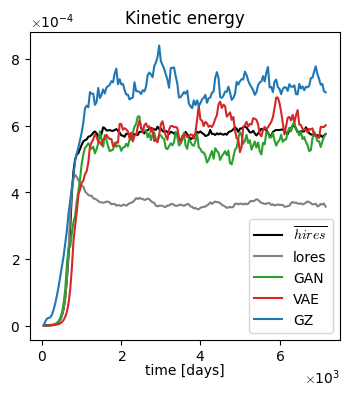

In [45]:
KE(reference).plot(label='$\overline{hires}$', color='k')
KE(lores).plot(label='lores', color='gray')
KE(gan).plot(label='GAN', color='tab:green')
KE(vae).plot(label='VAE', color='tab:red')
KE(gz).plot(label='GZ', color='tab:blue')
plt.title('Kinetic energy')
plt.legend()

# Snapshots

In [46]:
def sel(ds):
  try:
    return ds.isel(run=0, time=-1, lev=0)
  except:
    return ds.isel(time=-1, lev=0)

In [49]:
def plot_velocity(ds):
  imshow(np.sqrt(sel(ds.u)**2+sel(ds.v)**2), vmax=1.3e-1, cmap='inferno', cbar_label='Velocity modulus, $m/s$')

Text(0.5, 0.98, 'Sharp filter, 48x48, time step 4 hours')

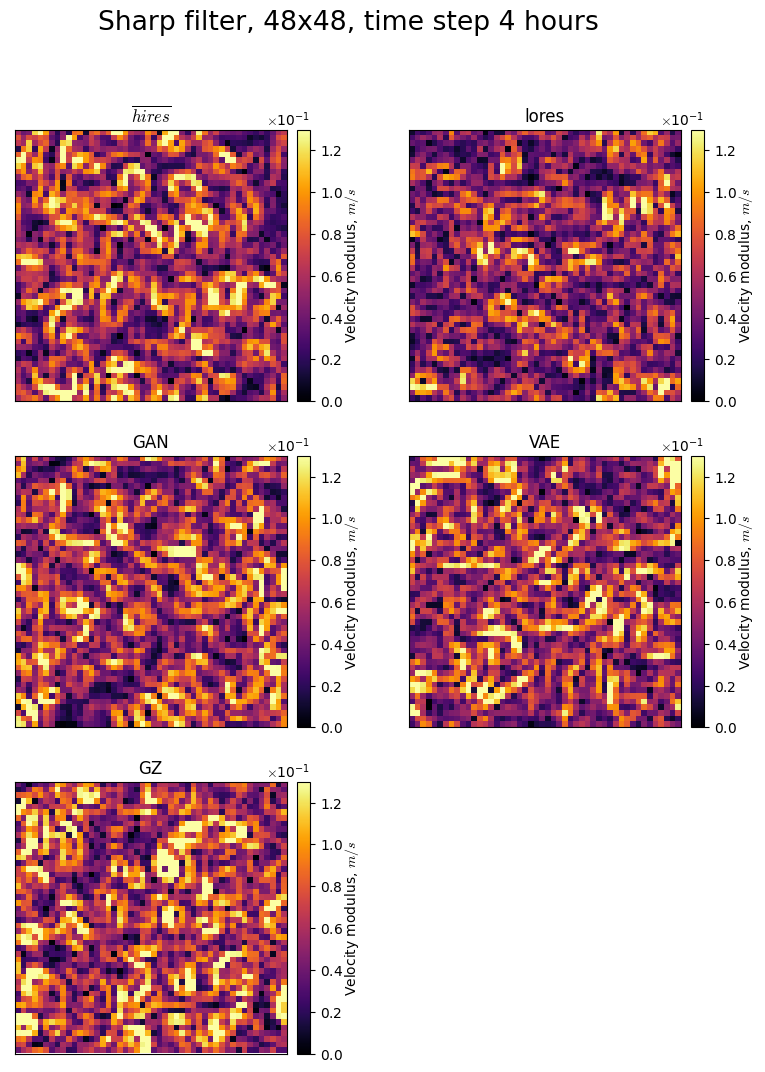

In [64]:
plt.figure(figsize=(9,12))
model = [reference, lores, gan, vae, gz]
label = ['$\overline{hires}$', 'lores', 'GAN', 'VAE', 'GZ']
for j in range(5):
  plt.subplot(3,2,j+1)
  plot_velocity(model[j])
  plt.title(label[j])
plt.suptitle('Sharp filter, 48x48, time step 4 hours')

# KE spectrum

In [87]:
from pyqg_generative.tools.spectral_tools import spectrum, calc_ispec
from pyqg_generative.tools.operators import coord
import pyqg

In [103]:
def KE_spectrum(ds):
  m = pyqg.QGModel(nx=len(ds.x), log_level=0)
  if 'run' in ds.dims:
    _ds = ds.mean('run')
  else:
    _ds = ds
  k, sp = calc_ispec(m, 0.5*ave_lev(_ds.KEspec, delta=0.25))
  return xr.DataArray(sp, dims=['kr'],
                coords=[coord(k, 'wavenumber, $m^{-1}$')])

(0.05, 20)

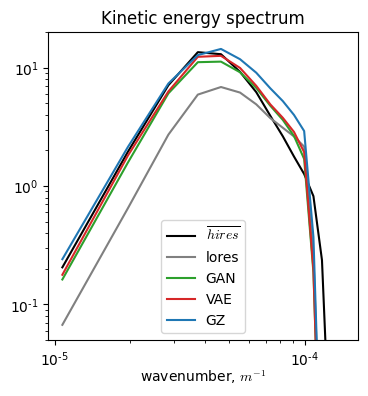

In [104]:
KE_spectrum(reference).plot(label='$\overline{hires}$', color='k')
KE_spectrum(lores).plot(label='lores', color='gray')
KE_spectrum(gan).plot(label='GAN', color='tab:green')
KE_spectrum(vae).plot(label='VAE', color='tab:red')
KE_spectrum(gz).plot(label='GZ', color='tab:blue')
plt.title('Kinetic energy spectrum')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylim([5e-2, 20])

# Online metrics. Distributional and spectral errors

In [117]:
from pyqg_generative.tools.comparison_tools import diagnostic_differences_Perezhogin, distrib_score, spectral_score

In [118]:
def compute_metrics(model):
  d = diagnostic_differences_Perezhogin(model, reference.isel(run=0))[0]
  print('Distributional error', distrib_score(d))
  print('Spectral error', spectral_score(d))


In [119]:
compute_metrics(gan)

Distributional error 0.0303136207614699
Spectral error 0.15511599810711668


In [120]:
compute_metrics(vae)

Distributional error 0.033766709235370576
Spectral error 0.11307309301674046


In [121]:
compute_metrics(gz)

Distributional error 0.13136662366761906
Spectral error 0.27682951823059315


In [122]:
compute_metrics(lores.isel(run=0))

Distributional error 0.1888102207415551
Spectral error 0.5053847264088392
